# Seasonal Effects

When predicting the outcome of a future match, we must for the most part rely on historical match data to provide numerical estimates of predictive factors. Within each season we
face the problem of data scarcity and estimator variability, since the number of matches only increases over the season. Hence, an aggregation of pre-season match data might be useful for providing prior estimates of quantities of interest.
The purpose of this notebook is to examine what effect, if any, that historical seasonal match data has on predictability.

## Load the data

In [1]:
import sys
import os

sys.path.append(os.path.join("..", "python"))

In [2]:
import match_tools
from stats_tools import logistic, logit

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Load match results

In [5]:
df_matches = pd.read_csv(os.path.join("..", "data", "matches.csv"))

In [6]:
match_tools.add_timestamp(df_matches)

In [7]:
df_matches

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type,timestamp
0,1990,R1,Sat 31-Mar-1990 2:10 PM,M.C.G.,Melbourne,False,6,2,4,1,...,4,3,4,89,0,False,False,True,defeated,1990-03-31 14:10:00
1,1990,R1,Sat 31-Mar-1990 2:10 PM,Waverley Park,Geelong,True,5,3,2,3,...,7,10,6,192,4,True,False,False,lost-to,1990-03-31 14:10:00
2,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,3,6,5,104,4,True,False,False,lost-to,1990-03-31 14:10:00
3,1990,R1,Sat 31-Mar-1990 2:10 PM,Windy Hill,Essendon,True,7,4,6,7,...,3,2,4,60,0,False,False,True,defeated,1990-03-31 14:10:00
4,1990,R1,Sat 31-Mar-1990 7:40 PM,Carrara,Brisbane Bears,True,4,3,3,2,...,3,3,2,74,0,False,False,True,defeated,1990-03-31 19:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,2022,R18,Sat 16-Jul-2022 5:30 PM,Perth Stadium,Fremantle,True,3,3,3,2,...,4,5,4,82,4,True,False,False,lost-to,2022-07-16 17:30:00
6166,2022,R18,Sat 16-Jul-2022 7:25 PM,M.C.G.,Carlton,True,4,1,1,0,...,2,2,5,85,4,True,False,False,lost-to,2022-07-16 19:25:00
6167,2022,R18,Sun 17-Jul-2022 1:10 PM,M.C.G.,Hawthorn,True,2,3,7,0,...,2,3,0,77,0,False,False,True,defeated,2022-07-17 13:10:00
6168,2022,R18,Sun 17-Jul-2022 2:50 PM,Traeger Park,Melbourne,True,0,4,5,3,...,3,3,3,69,0,False,False,True,defeated,2022-07-17 14:50:00


### Load end-of-season statistics

In [8]:
df_seasonal = pd.read_csv(os.path.join("..", "data", "end_season_features.csv"))

In [9]:
df_seasonal

,season,team,teams,games,wins,draws,losses,wins_ratio,points_for,points_against,...,behinds_against,accuracy_against,goals_ratio,behinds_ratio,rank,rank_score,wins_prestige,adj_wins_prestige,points_prestige,adj_points_prestige
0,1990,Brisbane Bears,14,22,4,0,18,0.181818,1733,2426,...,338,0.507289,0.415126,0.426146,14,0.000000,0.003774,0.046936,0.049030,0.401289
1,1990,Carlton,14,22,11,0,11,0.500000,2277,2187,...,315,0.497608,0.517774,0.458763,8,0.461538,0.055508,0.433112,0.073333,0.507091
2,1990,Collingwood,14,26,19,1,6,0.750000,2798,2077,...,313,0.484349,0.578797,0.544396,1,1.000000,0.232418,0.797419,0.096696,0.581871
3,1990,Essendon,14,25,18,0,7,0.720000,2742,2079,...,297,0.500000,0.571429,0.552036,2,0.923077,0.172837,0.730920,0.096170,0.580403
4,1990,Fitzroy,14,22,7,0,15,0.318182,1874,2389,...,319,0.519578,0.433498,0.476190,12,0.153846,0.019412,0.204675,0.057674,0.443097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2022,Richmond,18,17,9,0,8,0.529412,1631,1418,...,200,0.503722,0.540724,0.496222,8,0.588235,0.035989,0.388251,0.058767,0.514896
541,2022,St Kilda,18,17,9,0,8,0.529412,1333,1311,...,195,0.488189,0.509235,0.472973,10,0.470588,0.052259,0.483842,0.057077,0.507158
542,2022,Sydney,18,17,11,0,6,0.647059,1546,1280,...,176,0.511111,0.549020,0.534392,6,0.705882,0.103283,0.661940,0.065234,0.542620
543,2022,West Coast,18,17,2,0,15,0.117647,1084,1888,...,202,0.581781,0.361364,0.391566,17,0.058824,0.008256,0.123970,0.032211,0.361357


In [10]:
all_seasons = sorted(set(df_seasonal.season))

# Exclude the last season, as it is currently incomplete
removed_season = all_seasons[-1]
all_seasons = all_seasons[:-1]
df_seasonal = df_seasonal.loc[df_seasonal.season < removed_season].copy()

## Basic modelling

For an arbitrary match between some team A and some opposing team B, the key estimate of interest is the probability of team A winning the match, and the complementary probability of team B winning.
We also have to account for drawn matches; however, as draws are relatively rare events, we may discount them here (after adjustment of the various numerical estimates).

Prior to each match of interest, we may use historical match data to compute quantities of interest.
As proxies for the probabilities of winning a match, we focus on proportional quantities, such as the proportion of previous games won, or the proportion of previous points scored, et cetera.

There are several modelling effects of which we need to be aware, namely logistic regression,
reversion to the mean, and the meaning of the intercept.

### Logistic regression

Suppose that we wish to estimate the probability $p_T$ of team T winning a match against an arbitrary opponent, using some computed variate $x_T$. It is tempting to assume that all unmodelled effects are captured by some
stochastic residual $\epsilon\in\mathbb{R}$, such that our predictive model takes the form
\begin{eqnarray}
p_T & = & f(x_T) + \epsilon\,.
\end{eqnarray}
However, this simplistic model has the problem that there are strong constrtaints on $\epsilon$ due to the requirement that $p_T\in[0,1]$. 

One way to account for this is to use a *logistic* transformation $\sigma:\mathbb{R}\mapsto[0,1]$, defined as $\sigma(x)\doteq(1+e^{-x})^{-1}$,
and its inverse *logit* transformation $\sigma^{-1}:[0,1]\mapsto\mathbb{R}$, defined as
$\sigma^{-1}(p)\doteq\ln\frac{p}{1-p}$. These transformations rely on the fact that the natural link function for a proportion is the logit, i.e. $y_T=\sigma^{-1}(p_T)$. Consequently, the unconstrained model is now
\begin{eqnarray}
y_T~=~f(x_T) + \epsilon & \Leftrightarrow & p_T~=~\sigma\left(f(x_T)+\epsilon\right)\,.
\end{eqnarray}


From a distributional point of view, the two fundamental assumptions are that the residual is unconditionally unbiased and uncorrelated with the model. The first constraint provides the predictive model, namely
\begin{eqnarray}
\mathbb{E}\left[\epsilon\right]~=~0 & \Rightarrow \mathbb{E}\left[\epsilon\mid x_T\right]~=~0
& \Rightarrow
\hat{y}_T~=~\mathbb{E}\left[y_T\mid x_T\right]~=~f(x_T)\,,
\end{eqnarray}
and the second constraint provides the so-called *normal* equation(s), namely
\begin{eqnarray}
\mathtt{Cov}\left[\epsilon,f(x_T)\right] & = & \mathbb{E}\left[\epsilon\,f(x_T)\right] ~=~ 0\,.
\end{eqnarray}

From a model fitting point of view, we now replace the expectations by a sample averaging function $\langle\cdot\rangle$,
such that, in practice, the normal equations become
\begin{eqnarray}
\langle\epsilon\rangle~=~0 & \Rightarrow & \langle y_T\rangle~=~\langle f(x_T)\rangle\,,
\\
\langle\epsilon f(x_T)\rangle~=~0 & \Rightarrow & 
\langle y_T\,f(x_T)\rangle~=~\langle f(x_T)^2\rangle\,,
\end{eqnarray}
where it is to be understood that $\langle x_T\rangle$ averages the $x$ variate over all sample cases, i.e. over all teams and all matches.

### Mean reversion

If an explanatory variate $x_T$ has the same domain as the predicted variate $y_T$,
then it is natural to assume they are related by the identity $f(x)=x$. However, since matches are played over time, we are essentially using a temporal model. It is well known that for many time series, e.g. financial prices, there seems to be a *reversion-to-the-mean* effect, such that prices vary over time around some mean value. For sporting matches, there also seems to be evidence of mean reversion,
such that very good or bad matches for any given team might likely be followed by more average ones.
This also applies in aggregate, whereby a good or bad season might be followed by an average one.

Hence, instead of using an identity function, we allow for the possibility of mean reversion
by fitting the linear (actually *affine*) relationship
\begin{eqnarray}
y_T~=~\alpha+\beta x_T+\epsilon & ~\Rightarrow~ & \hat{p}_T~=~\sigma\left(\alpha+\beta x_T\right)\,. 
\end{eqnarray}
If $0<\beta<1$, then this is equivalent to the mean-reversion model
\begin{eqnarray}
y_T & = & \mu+\beta(x_T-\mu)+\epsilon\,, 
\end{eqnarray}
with $\mu=\frac{\alpha}{1-\beta}$.

The normal equations now become
\begin{eqnarray}
\langle y_T\rangle & = & \hat{\alpha} + \hat{\beta}\,\langle x_T\rangle\,,
\\
\langle x_T\,y_T\rangle & = & \hat{\alpha}\,\langle x_T\rangle + 
\hat{\beta}\,\langle x_T^2\rangle\,,
\end{eqnarray}
from which we obtain the parameter estimates
\begin{eqnarray}
\hat{\beta} & = & 
\frac{\langle x_T\,y_T\rangle - \langle x_T\rangle\,\langle y_T\rangle}
     {\langle x_T^2\rangle - \langle x_T\rangle^2}
\,,
\\
\hat{\alpha} & = & \langle y_T\rangle - \hat{\beta}\,\langle x_T\rangle\,.
\end{eqnarray}
These estimates provably minimise the squared residual $\langle\epsilon^2\rangle$, thus providing
the (ordinary) least-squares (OLS) estimates. In other words, these estimators are unbiased and achieve
minimum variance.

### One-team versus two-team modelling

The simplest two-team logistic model is given by
\begin{eqnarray}
P(\texttt{win}_A\mid A,B) & \doteq & \sigma\left[\beta\,(x_A-x_B)+\epsilon\right]\,,
\end{eqnarray}
for team features $x_A,x_B\in\mathbb{R}$, where $x_A$ denotes the evidence in favour of team A, and $x_B$ denotes
the evidence in favour of team B.
We notionally posit the existence of some nameless 'average' team with average feature 
$\langle x_A\rangle=\langle x_B\rangle$,
such that $x_A\approx\langle x_A\rangle$ means that team A usually performs around average, 
whereas $x_A>\langle x_A\rangle$ means that team A usually performs above average, 
and conversely $x_A<\langle x_A\rangle$ means that team A usually performs below average. 

We now suppose that, given some team A, averaging the two-team model over all opposing teams is approximately equivalent
to team A playing against an arbitrary, average team (this is the *mean field approximation*). This leads to the one-team model
\begin{eqnarray}
p_A & = & P(\texttt{win}_A\mid A,*)~\doteq~\sigma\left[\beta\,(x_A-\langle x_A\rangle)+\epsilon\right]
\\
\Rightarrow y_A & = & \sigma^{-1}\left(p_A\right)
~=~\beta\,(x_A-\langle x_A\rangle)+\epsilon~=~\alpha+\beta\,x_A+\epsilon
\,,
\end{eqnarray}
with $\alpha=-\beta\,\langle x_A\rangle$. 
Observe that this latter model is just
the linear logistic model of the [previous](#Mean-reversion "Section: Mean reversion") section,
where we saw that the (estimates of the) coefficients $\alpha$ and $\beta$ must satisfy
$\alpha=\langle y_A\rangle-\beta\,\langle x_A\rangle$. Therefore, exact equivalence between the two models
requires that $\langle y_A\rangle=0$.

How does the constraint $\langle y_A\rangle=0$ arise?
The answer comes from the modelling of conserved quantities, namely the number of wins, or the number of goals, or behinds, or points scored, et cetera. For example, every match won by some team is a match lost by another team. Consequently,
the total number of wins over all teams equals the total number of losses, and the average proportion of wins equals the average proportion of losses, i.e. 0.5. 

To put this another way, consider the proportion
\begin{eqnarray}
p_A & \doteq & \frac{w_A}{w_A+\ell_A}~=~\frac{1}{2}+\delta_A\,,
\end{eqnarray}
where $w_A$ and $\ell_A$ represent the complementary counts of a conserved quantity, e.g. the number of wins for team A 
versus the number of losses for team A, respectively. 
Now, if some team, say team A, scores above average, i.e. $\delta_A>0$, then some other team, say team B, must score below
average, i.e. $\delta_B=-\delta_A<0$. Note that an exactly average team T, with $\delta_T=0$, need not be paired with a complementary team.

By construction, therefore, we must have $\langle \delta_A\rangle=0$ and $\langle p_A\rangle=0.5$, averaged over all teams. It now follows from the (anti-)symmetry of the logit function about $p=\frac{1}{2}$, i.e.
$\sigma^{-1}\left(\frac{1}{2}-\delta\right)=-\sigma^{-1}\left(\frac{1}{2}+\delta\right)$, that 
$\langle y_A\rangle=\langle\sigma^{-1}(p_A)\rangle=0$.

This now leaves us with the constraint that $\alpha=-\beta\,\langle x_A\rangle$ for the one-team model.
Consequently, if the variate $x_A$ has been *decentred* such that $\langle x_A\rangle=0$, then the model fit will require no intercept, i.e. $\alpha=0$. Conversely, if the best fit requires intercept $\alpha\neq 0$, then it is apparent that
$\langle x_A\rangle\neq 0$. Recalling that the one-team model was obtained from the two-team model by replacing
opponent variate $x_B$ by its average $\langle x_B\rangle = \langle x_A\rangle$, we also deduce that a
non-zero intercept implies the presence of an opponent-specific effect that is more properly treated by the two-team model.
In other words, if $\langle x_A\rangle\neq 0$ then $x_A$ is not an 'absolute' measure, but must be interpreted relative
to all other teams.  We shall observe this effect is later analyses.

## Seasonal prediction

We begin by looking at the reliability of the various agglomerated statistics at the end of each season, and then examine how well statistics from the previous season can be used to predict the current season.
We [recall](3_feature_extraction.ipynb#Numbers-of-wins,-draws-and-losses
"Feature Extraction: Numbers of wins, draws and losses") 
that the *wins ratio* measures the proportion of all games within a given season won by a team (with allowances for draws). This gives an objective measure of a team's strength or weakness for that season. However, the measure is coarse, since a loss by 1 point is no different to a loss by 100 points. A more refined measure would therefore take account of the points margin of wins and losses (with zero margin for a draw).
We
[recall](3_feature_extraction.ipynb#Points-for-and-against
"Feature Extraction: Points for and against") that such a measure is provided by the *points ratio*, although this quantity has a more subjective interpretation than the wins ratio.

Another features of interest is the *rank score*, which is derived from the
[league rankings](3_feature_extraction.ipynb#League-ranking
"Feature Extraction: League ranking") but normalised to be independent of the number of teams.
Finally, the last feature of interest is the *prestige score*, which measures
the fictional flow of 
[prestige](3_feature_extraction.ipynb#Prestige-scores
"Feature Extraction: Prestige scores") from losing teams to winning teams. 
Note that we utilise adjusted versions of both these measures,
that are normalised to be comparable between different seasons with different numbers of teams.

### End-of-season relationships

Our first test of the predictive effect of various features is to examine their relationships within the same
season. Note that this is not really a fair test, since the outcome of each match contributes to both
the wins ratio and the points ratio, and the wins (and draws) determine the match points from which the league rankings are derived (using points scored for ties). Our test, therefore is merely meant to be indicative in the sense that the various aggregated features should be strongly correlated with each other.

In [11]:
def cross_estimate_subplot(ax, X, Y, x_field, y_field):
    ax.plot(X, Y, 'o')
    x = np.linspace(np.min(X), np.max(X), 100)
    y = np.linspace(np.min(Y), np.max(Y), 100)
    mu_x = np.mean(X)
    mu_y = np.mean(Y)
    ax.plot(x, [mu_y] * len(x), 'black')
    ax.plot([mu_x] * len(y), y, 'darkgrey')

    X = X.reshape((-1, 1))    
    model = LinearRegression(fit_intercept=False).fit(X, Y)
    beta0 = model.coef_[0]
    y = beta0 * x
    ax.plot(x, y, 'g')

    model = LinearRegression(fit_intercept=True).fit(X, Y)
    R2 = model.score(X, Y)
    alpha = model.intercept_
    beta = model.coef_[0]
    y = alpha + beta * x
    ax.plot(x, y, 'r')

    ax.set(xlabel=f"Predictor: {x_field}", ylabel=f"Predicted: {y_field}")
    ax.legend(['data','y-mean', 'x-mean', 'no intercept','with intercept'])
    return R2, alpha, beta, beta0


def cross_estimate_plot(x_field, y_field):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Cross-estimate predictability')
    X = df_seasonal[x_field].values
    Y = df_seasonal[y_field].values
    res1 = cross_estimate_subplot(ax1, X, Y, x_field, y_field)
    X = logit(X)
    Y = logit(Y)
    x_field = "logit(" + x_field + ")"
    y_field = "logit(" + y_field + ")"
    res2 = cross_estimate_subplot(ax2, X, Y, x_field, y_field)
    plt.tight_layout()
    plt.show()
    return res1[0], res2[0]

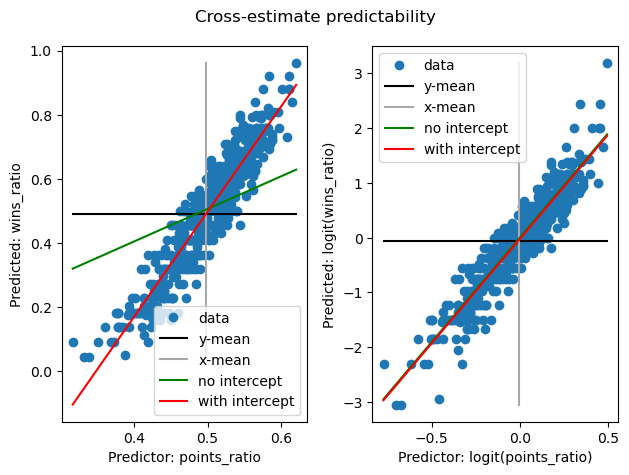

R^2=0.8754510845065487, 0.8719434302788477


In [12]:
res = cross_estimate_plot('points_ratio', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

There are two interesting observations to make here. Firstly, the $R^2$ values are similar for fitting a straight line to both the raw proportions and the logit-transformed values, indicating that either model night be useful. Secondly, although the proportional model appears to need an intercept for best fit, the logit model appears to not need one, making it the simpler model. As we discussed [earlier](#One-team-versus-two-team-modelling 
"Section: One-team versus two-team modelling"), this implies that the points ratio for a given team is a useful, *marginal*
predictor of the wins ratio for that team, irrespective of the opponent.

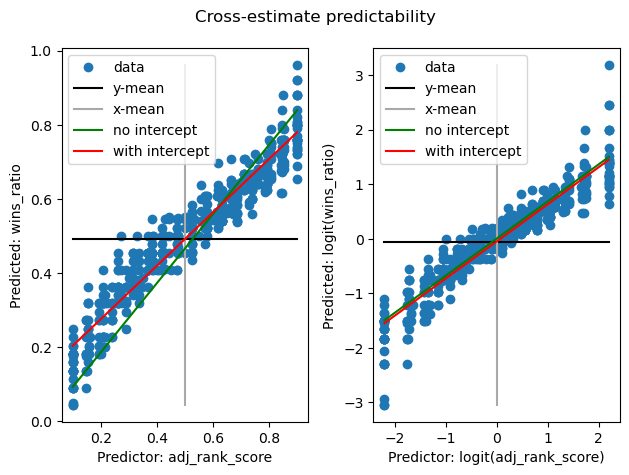

R^2=0.9187584427643046, 0.8908069832396187


In [13]:
# Map scores [0, 1] -> [0.1, 0.9] to avoid log(0) 
df_seasonal['adj_rank_score'] = 0.8 * df_seasonal.rank_score + 0.1

res = cross_estimate_plot('adj_rank_score', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

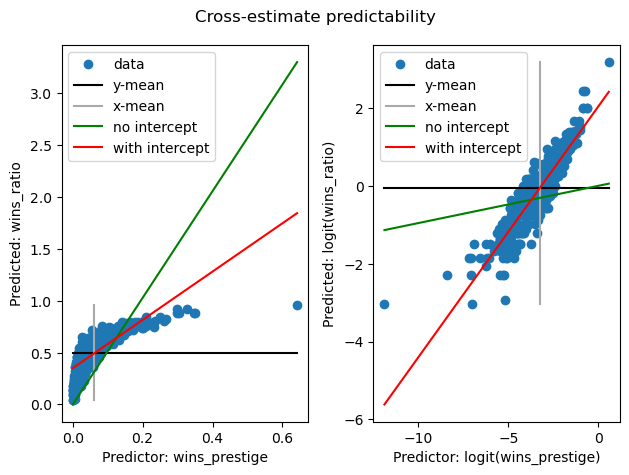

R^2=0.6188299362245212, 0.8358034079239074


In [14]:
res = cross_estimate_plot('wins_prestige', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

Here we observe the clear advantage of the logit model over the proportional model, where most of the nonlinearity has been 'straightened' out. However, this time the logit model also requires an intercept for best fit. This indicates that the *wins prestige* feature for each team must be taken relative to all other opposing teams, i.e. it is not an absolute measure.

This is true of all (unadjusted) centrality and prestige scores. To see this, suppose a vertex in a graph has a normalised score of  $\frac{1}{3}$. Is this value big or small? Recalling that the average, normalised vertex score of an $N$-vertex graph is 
$\frac{1}{N}$, we see that $\frac{1}{3}$ is smaller than average for $N=2$, exactly average for $N=3$, and
greater than average for $N\ge 4$. In other words, centrality and prestige scores are relative to the size of the graph, and act more like ordinal values that may be ranked, rather than ratio values than can be numerically compared.

To put it another way, since the number $N$ of teams in the league changes over time, any unadjusted feature that depends upon $N$ is not comparable across seasons, and cannot be used to build a model that is valid over multiple seasons.

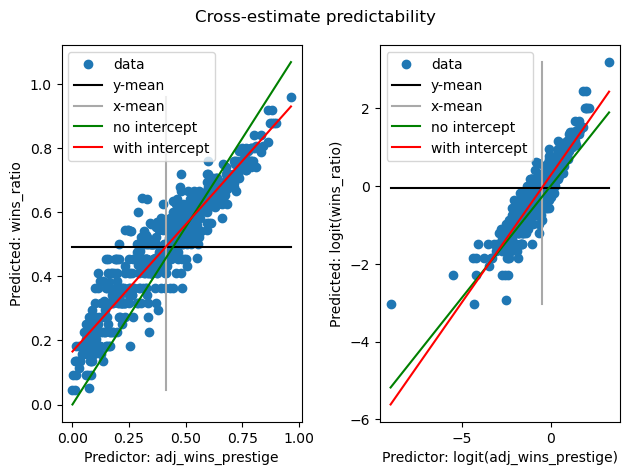

R^2=0.8670120121643263, 0.844436092540626


In [15]:
res = cross_estimate_plot('adj_wins_prestige', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

In contrast to the unadjusted wins prestige score analysed above, the *adjusted* wins prestige is (almost) an absolute measure, and can be used without any knowledge of the opponent. This is not surprising, since the adjustment
was [explicitly designed](B_graph_analytics.ipynb#Probabilistic-modelling "Appendix B: Probabilistic modelling")
to account for arbitrary opponents.

Alternatively, the [analysis](#One-team-versus-two-team-modelling 
"Section: One-team versus two-team modelling")
of the linear model
indicates that we should enforce $\langle x\rangle=0$ across all seasons, which can be achieved if we enforce $\langle x\rangle=0$ within each season. This suggests another possible normalisation of prestige and centrality scores, namely
setting
\begin{eqnarray}
p_T' & \doteq & \sigma\left[\sigma^{-1}(p_T)-\langle\sigma^{-1}(p)\rangle\right]\,,
\end{eqnarray}
where the average measure, i.e.
\begin{eqnarray}
\langle\sigma^{-1}(p)\rangle & = & \frac{1}{|\mathcal{T}|}\sum_{T\in\mathcal{T}}\sigma^{-1}(p_T)\,,
\end{eqnarray}
is computed
for each graph of $N=|\mathcal{T}|$ teams. 

In [16]:
df_seasonal['adj2_wins_prestige'] = 0.0

for season in all_seasons:
    ind = df_seasonal.season == season
    scores = df_seasonal.loc[ind, 'wins_prestige']
    new_scores = logit(scores.values)
    new_scores -= np.mean(new_scores)
    new_scores = logistic(new_scores)
    df_seasonal.loc[ind, 'adj2_wins_prestige'] = new_scores

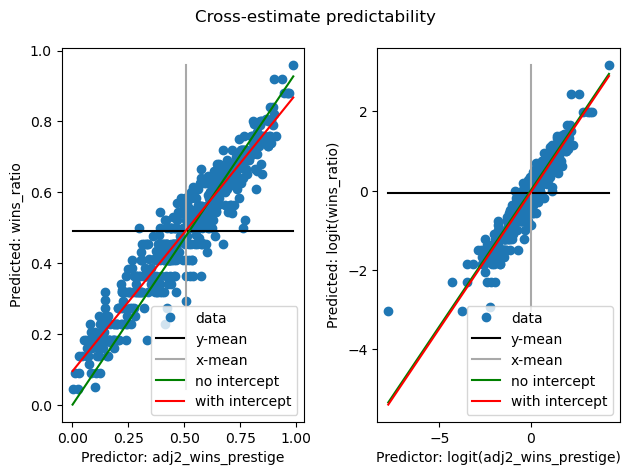

R^2=0.9066422480597687, 0.8856787823617946


In [17]:
res = cross_estimate_plot('adj2_wins_prestige', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

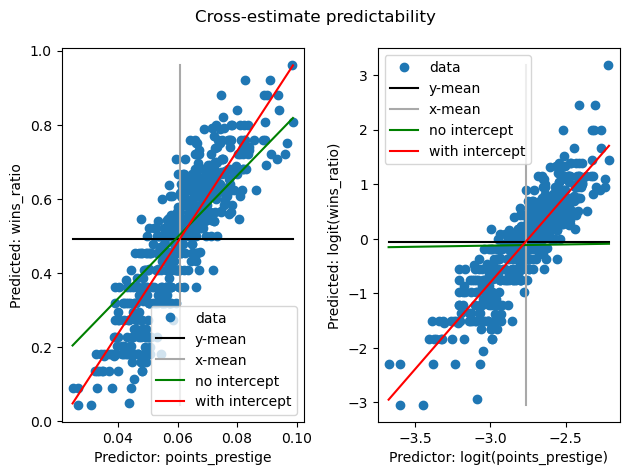

R^2=0.7605995123662842, 0.7630184056259803


In [18]:
res = cross_estimate_plot('points_prestige', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

Similarly to the wins prestige score analysed above, the points prestige score is a relative measure, as indicated by the presence of an intercept in the logit model. Thus, once again, the score cannot be interpreted without the context of all $N-1$ opposing teams.

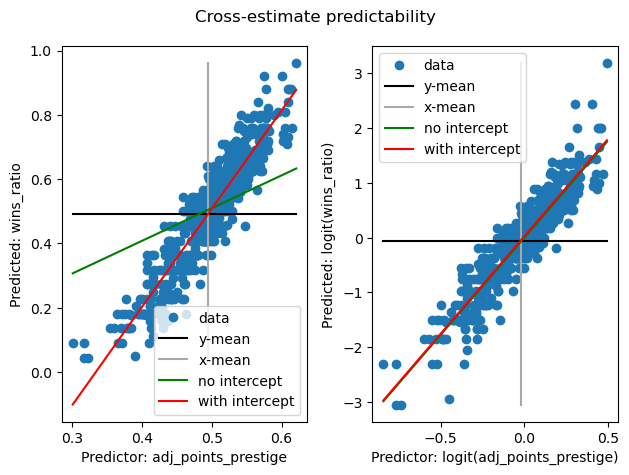

R^2=0.8575924705117781, 0.85134188745206


In [19]:
res = cross_estimate_plot('adj_points_prestige', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

In [20]:
df_seasonal['adj2_points_prestige'] = 0.0

for season in all_seasons:
    ind = df_seasonal.season == season
    scores = df_seasonal.loc[ind, 'points_prestige']
    new_scores = logit(scores.values)
    new_scores -= np.mean(new_scores)
    new_scores = logistic(new_scores)
    df_seasonal.loc[ind, 'adj2_points_prestige'] = new_scores

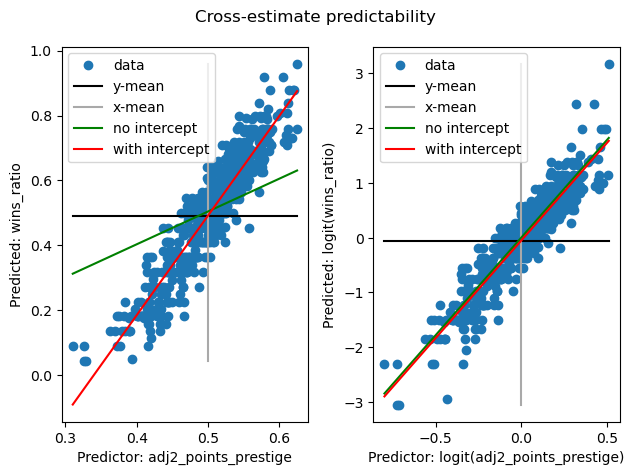

R^2=0.8582860041681353, 0.8515408468830706


In [21]:
res = cross_estimate_plot('adj2_points_prestige', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

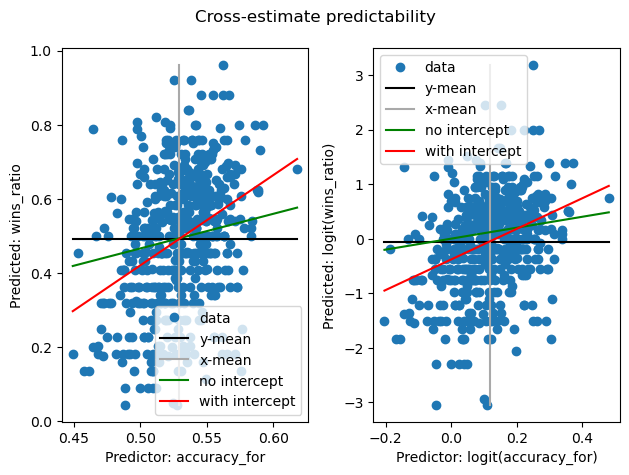

R^2=0.11880489440838471, 0.11453158038320754


In [22]:
res = cross_estimate_plot('accuracy_for', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

The goal accuracy, i.e. the proportion of scoring shots that are goals instead of behinds, does not appear to be a useful predictor due to its low $R^2$ value. This could be partly because it appears to be a relative measure. However, since the accuracy does not depend on the number of teams, it could be used in a 
[two-team model](#One-team-versus-two-team-modelling 
"Section: One-team versus two-team modelling"), where it might be more usefully compared to the opponent's accuracy.

In [23]:
df_seasonal['adj_accuracy_for'] = 0.0

for season in all_seasons:
    ind = df_seasonal.season == season
    scores = df_seasonal.loc[ind, 'accuracy_for']
    new_scores = logit(scores.values)
    new_scores -= np.mean(new_scores)
    new_scores = logistic(new_scores)
    df_seasonal.loc[ind, 'adj_accuracy_for'] = new_scores

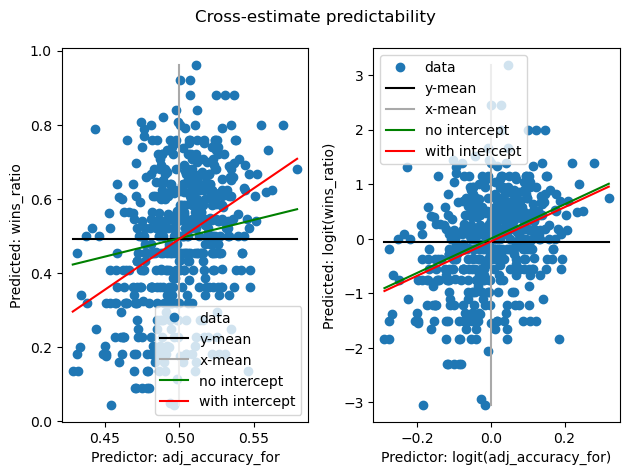

R^2=0.1335496135137697, 0.12786023646998068


In [24]:
res = cross_estimate_plot('adj_accuracy_for', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

Unfortunately, we have confirmed that the goal scoring accuracy is not a good predictive measure, even when adjusted relative to all other teams.

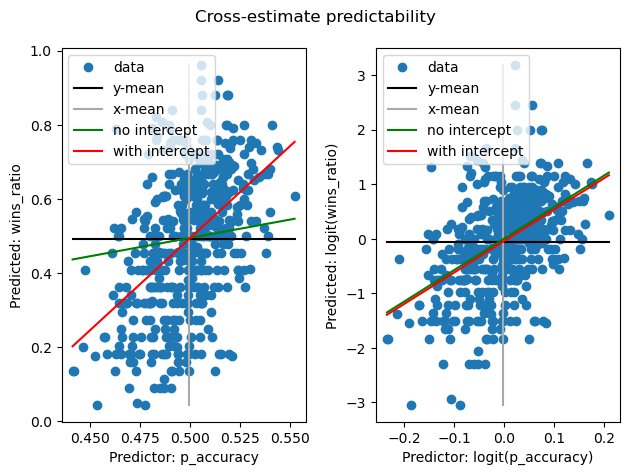

R^2=0.23682503922343634, 0.22786497590150323


In [25]:
acc_for = df_seasonal.accuracy_for.values
acc_against = df_seasonal.accuracy_against.values
p_acc = acc_for / (acc_for + acc_against)
df_seasonal['p_accuracy'] = p_acc

res = cross_estimate_plot('p_accuracy', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

Similarly, the ratio of the goal accuracy for opposing teams does not seem to be a useful predictor either, this time entirely due to the low $R^2$ value.

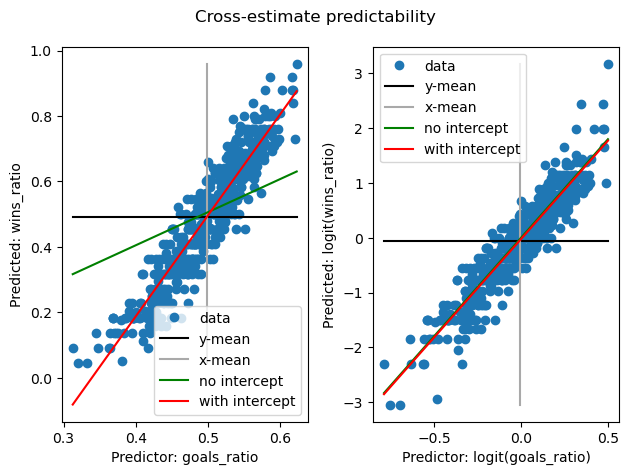

R^2=0.8677086030004084, 0.8626277178865014


In [26]:
res = cross_estimate_plot('goals_ratio', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

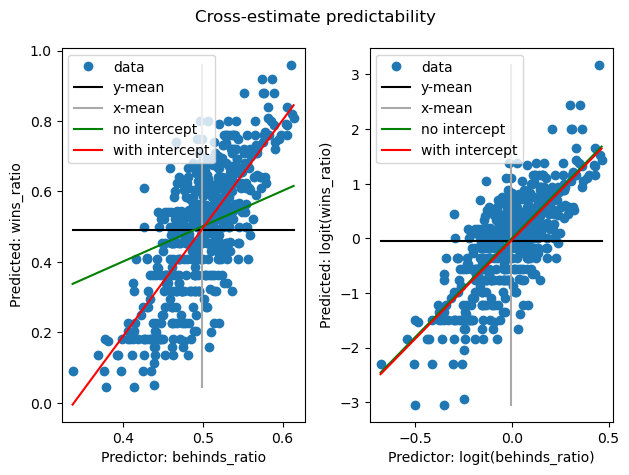

R^2=0.5551006788790225, 0.5628950215850756


In [27]:
res = cross_estimate_plot('behinds_ratio', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

We conclude that the seasonal features are, as expected, mostly strongly correlated with each other *within the same season*. The exception appears to be the measure of goal scoring accuracy, i.e. the proportion of scoring shots that are goals rather than behinds. 
One might expect that a high goal-scoring accuracy would be indicative of a strong team, which would in turn lead one to expect a higher proportion of wins for that team. However, it would seem that this accuracy is only a relative measure of team strength, and would need to be contrasted with the opposing team's accuracy.

### Inter-seasonal relationships

Our next test, a fairer one, is to examine the relationships between the features computed both at the end of one season and at the end of the next season. Such relationships directly indicate how strongly the results of  one season may be used to predict the next. The '*business as usual*' or *null* hypothesis is that one season is much like the next, subject to chance fluctuations. Mitigating against this hypothesis is the fact that,
as noted in the 
[introduction](1_introduction.ipynb#Temporal-heterogeneity "Introduction: Temporal heterogeneity"), 
teams change in player composition from season to season, and thus change in attacking and defending capabilities over time,
so that in some seasons a team might be systematically stronger or weaker than in other seasons.
This latter issue also suggests that there might be a 
[reversion-to-the-mean](#Mean-reversion "Section: Mean reversion") effect, such that a good or bad season for any given team might likely be followed by a more average season.

In [28]:
def inter_seasonal_features(prev_field, cur_field):
    prev_values = []
    cur_values = []
    it = iter(all_seasons)
    prev_season = next(it)
    prev_features = df_seasonal[df_seasonal.season == prev_season]
    for cur_season in it:
        cur_features = df_seasonal[df_seasonal.season == cur_season]
        for idx, team_features in cur_features.iterrows():
            team = team_features['team']
            ind = prev_features.team == team
            if not any(ind):
                # Team has merged or changed name
                continue
            cur_values.append(team_features[cur_field])
            prev_value = prev_features.loc[ind, prev_field].values[0]
            prev_values.append(prev_value)
        prev_features = cur_features
    return np.array(prev_values), np.array(cur_values)

In [29]:
def inter_seasonal_plot(x_field, y_field):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Seasonal predictability')
    X, Y = inter_seasonal_features(x_field, y_field)
    res1 = cross_estimate_subplot(ax1, X, Y, x_field, y_field)
    X = logit(X)
    Y = logit(Y)
    x_field = "logit(" + x_field + ")"
    y_field = "logit(" + y_field + ")"
    res2 = cross_estimate_subplot(ax2, X, Y, x_field, y_field)
    plt.tight_layout()
    plt.show()
    return res1[0], res2[0]

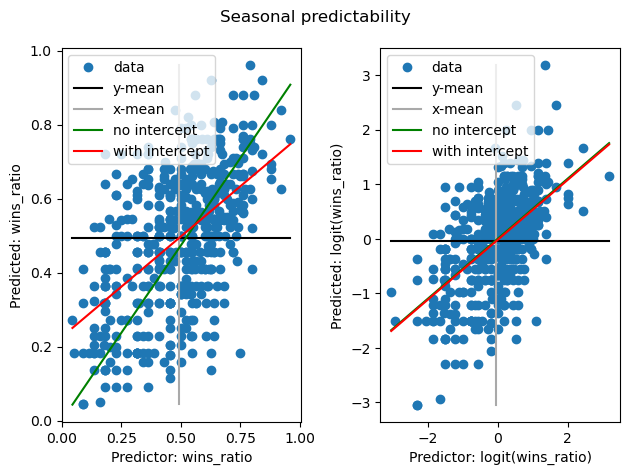

R^2=0.2950474161276585, 0.30056798264465245


In [30]:
res = inter_seasonal_plot('wins_ratio', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

Since the slope is less than unity, we conclude that there does seem to be a mean-reversion effect, such that more extreme wins ratios at the end of one season tend to be 'pulled' closer to the overall mean by the end of the subsequent season. However, there must also be contravailing (stochastic) effect that 'pushes' statistics away from the mean, otherwise there would be convergence to the mean over time. 

In [31]:
def inter_seasonal_plot(x_field, y_field):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Seasonal predictability')
    X, Y = inter_seasonal_features(x_field, y_field)
    X = logit(X)
    Y = logit(Y)
    x_field1 = "logit(" + x_field + ")"
    y_field1 = "logit(" + y_field + ")"
    res1 = cross_estimate_subplot(ax1, X, Y, x_field1, y_field1)
    X, Y = inter_seasonal_features(x_field, x_field)
    X = logit(X)
    Y = logit(Y)
    res2 = cross_estimate_subplot(ax2, X, Y, x_field1, x_field1)
    plt.tight_layout()
    plt.show()
    return res1[0], res2[0]

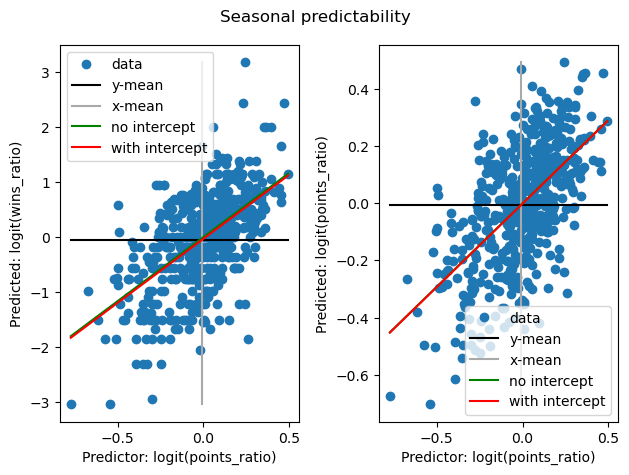

R^2=0.32489559498390275, 0.3448301105493795


In [32]:
res = inter_seasonal_plot('points_ratio', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

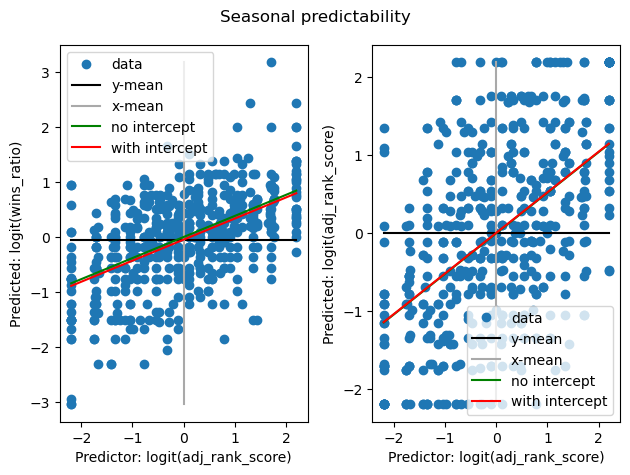

R^2=0.2807133944676454, 0.2705171931717606


In [33]:
res = inter_seasonal_plot('adj_rank_score', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

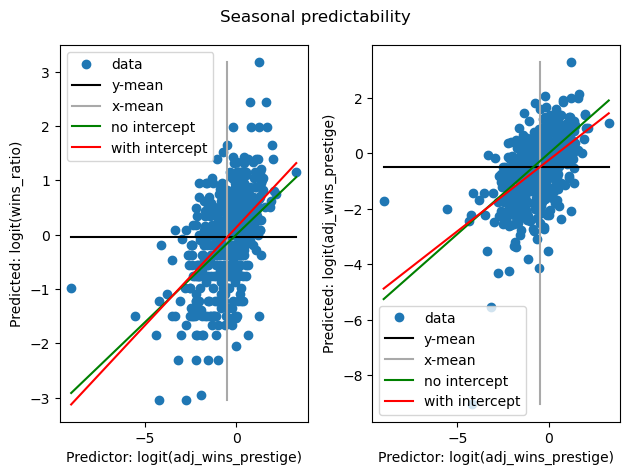

R^2=0.2595951559476354, 0.2678026306795642


In [34]:
res = inter_seasonal_plot('adj_wins_prestige', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

We observe that the least-square-error (LSE) fit is very sensitive to extreme values. Hence, in practice we should either use some other metric (e.g. absolute error), or some other technique (e.g. computing medians instead of means, or pruning oot extreme values and refitting).

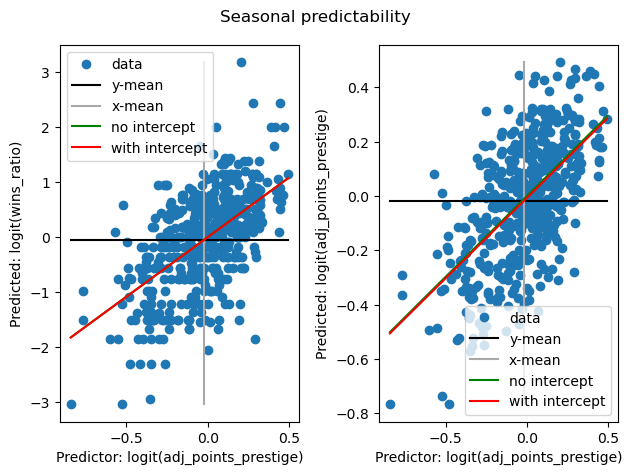

R^2=0.31693900058055546, 0.35775867707738296


In [35]:
res = inter_seasonal_plot('adj_points_prestige', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

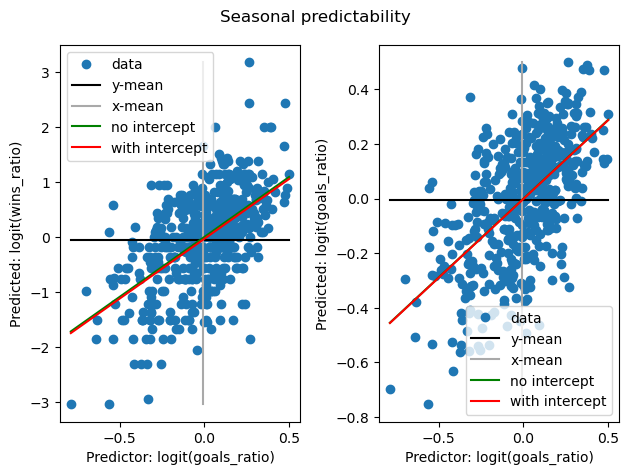

R^2=0.31443578789178483, 0.33755172767621056


In [36]:
res = inter_seasonal_plot('goals_ratio', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

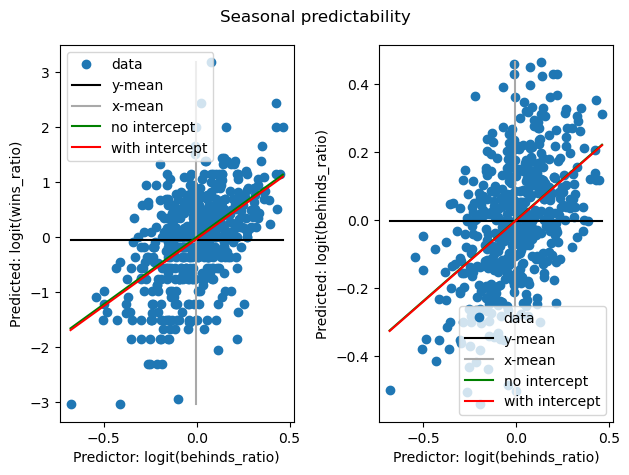

R^2=0.2596958303451571, 0.22943629495053264


In [37]:
res = inter_seasonal_plot('behinds_ratio', 'wins_ratio')
print(f"R^2={res[0]}, {res[1]}")

As expected, there is a larger amount of variability for inter-seasonal prediction compared to intra-seasonal prediction. However, overall there do seem to be weakly positive linear correlations, with the possible exception of the rank score, which appears visually to be fairly uncorrelated with the next season's wins ratio, and entirely uncorrelated with the next season's rank score.

Note that the lack of predictability from one season to the next, and the apparent presence of a mean reversion effect, can partly be attributed to the league player draft that happens at the end of each season, which is explicitly designed to allow weaker teams to draft stronger players, in order to help even out the competition for the next season.
In other words, we might expect the weakest teams in any one season to improve in the next season, at the expense of the 'average' teams.

However, the strongest teams would likely try to retain their best players, and might not be as affected by the draft, although they perhaps could afford to release some older players and take on some younger players, which might affect performance. In other words, it is unclear why or if truly strongs teams might be affected by reversion to an overall mean, unlike, say, teams that simply played better than expected in any given season. This raises the question of whether or not each individual team has its own underlying mean performance over time.

## Multi-seasonal prediction

In the [previous](#Seasonal-prediction "Section: Seasonal prediction") section,
we computed summary statistics aggregated over all matches per team within each season. With the aid of these per-season statistics, we also briefly examined the effect of predicting one season's statistics from the
previous season's statistics. Overall, with the exception of the rank score, there appeared to be a weak but definite predictive effect.

This raises the question of whether incorporating further past seasons will boost the predictive effect.
On the one hand, using multiple seasons might provide some measure of variability, and thus aid in smoothing
over exceptionally good or bad seasons. On the other hand, team changes over time possibly mean that a season long past may be a poor predictor of the future.

The proportions of wins, draws and losses for a given team for a particular season measure that team's success against all other teams,
and provide a predictor of the next season. That is, the proportions may be interpreted as probabilities.
Hence, we shall take a 
[weighted average](A_additive_weights.ipynb "Appendix A: Additively Weighted Models")
of the past seasons' proportions as a predictor of the proportions for the
following season.

Equivalently, we intend to fit a linear auto-regressive model to seasonal, per-team time-series data.
In order to get a feel for how difficult this task is in practice, we plot the wins ratio time-series below.

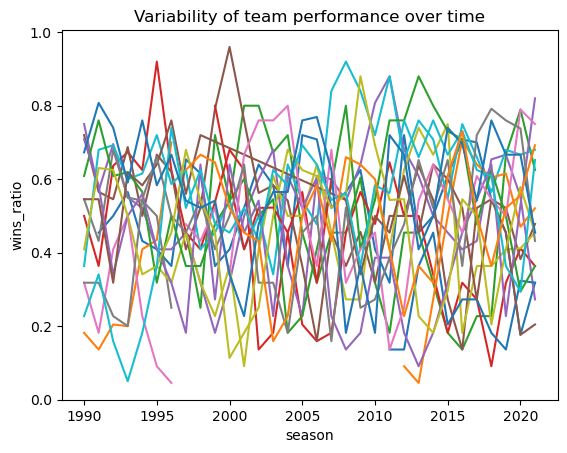

In [38]:
all_teams = sorted(set(df_seasonal.team))
for team in all_teams:
    team_data = df_seasonal.loc[df_seasonal.team == team, ['season', 'wins_ratio']]
    plt.plot(team_data.season, team_data.wins_ratio.values)
plt.title("Variability of team performance over time")
plt.xlabel('season')
plt.ylabel('wins_ratio')
plt.show()

### Extract seasonal proportions

We start our modelling by estimating the overall proportion of drawn matches. Other than draws, we expect *a priori* that the proportions of wins and losses should be equal.

In [39]:
prob_draw = sum(df_seasonal.draws) / sum(df_seasonal.games)
prob_win = prob_loss = (1 - prob_draw) / 2
prior_probs = np.array([prob_win, prob_draw, prob_loss])
print(prior_probs)

[0.49559581 0.00880838 0.49559581]


Since draws are rare events, the accurate prediction of drawn matches is problematic. To help ease this problem, we smooth the per-season statistics with the global prior before computing the proportions.

In [40]:
stats = ['wins', 'draws', 'losses']
df_experim = df_seasonal[['season', 'team', 'games'] + stats].copy()
for field in stats:
    df_experim[field] = df_experim[field].astype(float)

df_experim[stats] = df_experim[stats].values + prior_probs
for field in stats:
    df_experim[field] = df_experim[field] / (df_experim.games + 1)

In [41]:
df_experim

,season,team,games,wins,draws,losses
0,1990,Brisbane Bears,22,0.195461,0.000383,0.804156
1,1990,Carlton,22,0.499809,0.000383,0.499809
2,1990,Collingwood,26,0.722059,0.037363,0.240578
3,1990,Essendon,25,0.711369,0.000339,0.288292
4,1990,Fitzroy,22,0.325895,0.000383,0.673722
...,...,...,...,...,...,...
522,2021,Richmond,22,0.412852,0.043861,0.543287
523,2021,St Kilda,22,0.456330,0.000383,0.543287
524,2021,Sydney,23,0.645650,0.000367,0.353983
525,2021,West Coast,22,0.456330,0.000383,0.543287


We now collect the per-season proportions across all seasons for each team.

In [42]:
all_teams = sorted(set(df_experim.team))

team_data = {}
for team in all_teams:
    team_data[team] = df_experim.loc[df_experim.team == team, stats].values.copy()

### Temporal averaging

In order to measure the temporal effect of seasonal data, for each team we extract a collection of contexts and
targets. Each target represents the per-season statistics of a given team for a given season,
and the corresponding context represents the previous $K$ seasons of statistics.
In effect, for each team we take a sliding window of $K+1$ seasons as the training data.

In [43]:
from numpy.lib.stride_tricks import sliding_window_view

In [44]:
def get_target_contexts(team_data, num_context):
    values = next(iter(team_data.values()))
    num_classes = values.shape[1]  # C
    window_shape = (num_context + 1, num_classes)
    contexts = []  # N x K x C
    targets = []   # N x C
    for team, values in team_data.items():
        if values.shape[0] < window_shape[0]:
            # Too few seasons - ignore team
            continue
        sequences = sliding_window_view(values, window_shape)
        sequences = sequences[:, 0, :, :]
        contexts.append(sequences[:, :-1, :])
        targets.append(sequences[:, -1, :])
    contexts = np.vstack(contexts)
    targets = np.vstack(targets)
    return targets, contexts

Before we start the modelling, we should consider some aspects of both the data and the model.
Firstly, we only have about 30 years of data, due to our pre-determined date cut-off of 1990.
Hence, choosing $K\approx 30$ will run into problems with scarcity of data, thus affecting model fitting.
This problem should be reduced as $K$ becomes smaller, with $K\approx 15$ resulting in a sliding window of about 15 seasons to model about 15 future seasons. Beyond $K\approx 15$ might be problematic (i.e. producing untrustworthy results).

Secondly, we expect that as the number $K$ of model parameters increases, the model becomes more exprerssive and should fit the training data 
better and better (except near $K\approx 30$), thus typically leading to over-fitting. Furthermore, due to
the iterative nature of the parameter estimation, in the absence of parameter regularisation and model validation, we also expect over-fitting of the training data for any given $K$. Consequently, we should treat the interpretation of the resulting weights with some caution.

For convenience, we shall arbitrary take $K=15$ for the next analysis.

In [45]:
num_context = 15  # K
targets, contexts = get_target_contexts(team_data, num_context)
print(targets.shape)
print(contexts.shape)

(236, 3)
(236, 15, 3)


For the [additive model](A_additive_weights.ipynb#Additive-model
"Appendix A: Additive model"),
we give each season in the context a non-negative weight, say $w_k$, such that these weights sum to unity.
The overall prediction is then the weighted sum of the context.
We use
[quasi-supervised](A_additive_weights.ipynb#Quasi-Supervised-Training
"Appendix A: Quasi-Supervised Training")
training to choose these weights to minimise the cross-entropy of the context given the target.
Note that the contexts specify $P(c\mid\mathbf{x}_k^{(d)},\Theta)$, and the targets specify
$P(c\mid\vec{\mathbf{x}}^{(d)},\Gamma)$.

In [46]:
def score_weights(target_probs, context_probs, weights=None):
    num_context = context_probs.shape[1]  # K
    if weights is None:
        weights = np.ones(num_context) / num_context
    posterior_probs = [None] * num_context  # K x N x C
    # Compute P(k,c|x)
    for k in range(num_context):
        posterior_probs[k] = weights[k] * context_probs[:,k,:]
    # Compute P(c|x)
    predicted_probs = sum(posterior_probs)  # N x C
    # Compute L(Theta)
    L = np.mean(np.sum(target_probs * np.log(predicted_probs), axis=1))
    # Compute P(k|c,x)
    for k in range(num_context):
        posterior_probs[k] /= predicted_probs
    # Update P(k)
    new_weights = np.zeros(num_context)
    for k in range(num_context):
        new_weights[k] = np.mean(np.sum(target_probs * posterior_probs[k], axis=1))
    return L, new_weights

In [47]:
def iterate_estimates(target_probs, context_probs, tol=1e-8):
    scores = []
    L0, weights = score_weights(target_probs, context_probs)
    scores.append(L0)
    L1, weights = score_weights(target_probs, context_probs, weights)
    scores.append(L1)
    while L1 - L0 >= tol:
        L0 = L1
        L1, weights = score_weights(target_probs, context_probs, weights)
        scores.append(L1)
    return weights, scores

In [48]:
weights, scores = iterate_estimates(targets, contexts)
L1 = scores[-1]
L0 = scores[-2]
print(f"score={L1}, convergence={L1-L0}, #iterations={len(scores)}")
print("model weights:\n", weights)

score=-0.7198193632100739, convergence=9.97581506290146e-09, #iterations=1124
model weights:
 [7.14284458e-02 1.30747200e-02 3.70199044e-07 5.64091987e-02
 8.74928663e-02 1.67925672e-02 1.06680993e-03 1.22984977e-04
 6.59964929e-02 9.76020986e-06 3.01933786e-02 4.32734912e-02
 8.17450454e-02 4.03312412e-04 5.31990556e-01]


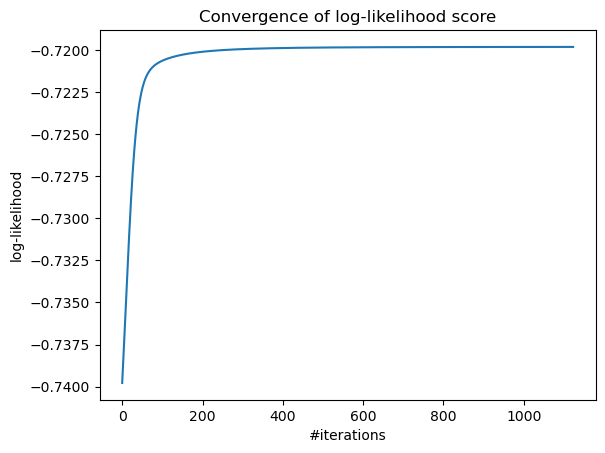

In [49]:
plt.plot(scores)
plt.title("Convergence of log-likelihood score")
plt.xlabel("#iterations")
plt.ylabel("log-likelihood")
plt.show()

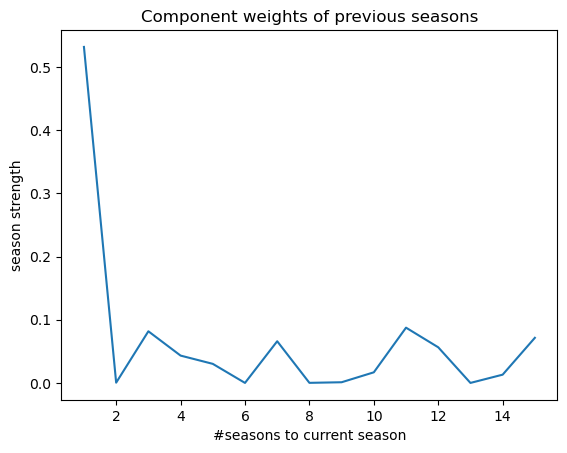

In [50]:
rweights = list(weights)
rweights.reverse()
steps = range(1, num_context + 1)

plt.plot(steps, rweights)
plt.title("Component weights of previous seasons")
plt.xlabel("#seasons to current season")
plt.ylabel("season strength")
plt.show()

We observe that the season immediately prior to a given season (say, $k=1$) is given the greatest weight (say $w_1$), with all other past seasons ($k>1$) given a low weight ($w_k$) of about the same magnitude, i.e. $\approx\frac{1}{K}$. 
In futher experiments (not shown here), this pattern persists irrespective of the number $K$ of
past seasons. We attach no significance to the variance in weights across the low-weighted seasons, since this oscillating variation also persists independently of $K$, except that the weights of past seasons may abitrarily be higher or lower as $K$ varies. We attribute this to over-fitting the data, as discussed above.

This pattern of weights also appears when optimisating models with other objective functions, e.g. linear regression using least square error (via stacking the $C$ classes of $N$ cases into $NC$ cases). Also note that, instead of a weighted additive model, one may use a weighted multiplicative model. Under the *logit* transform $\sigma^{-1}(p)=\ln\frac{p}{1-p}$ of the features, this may also be re-cast into a weighted additive model. Further experiments with this new model
also showed the same pattern of weights. In particular, use of `LassoCV`, i.e.
linear regression with an $L_1$ weight regulariser and using cross-validation, repeatedly gave zero or near-zero weights (for various values of $K$) for all except weight $w_1$, corresponding to $K=1$. The [next](#Predictive-accuracy "Section: Predictive accuracy") section explores some of these results for fitting linear regression models via `LassoCV`.

We conclude that, for the purposes of predicting the current season, only the previous season appears to hold sufficient information.

### Predictive accuracy

Despite the fact that the additive model gives most weight to $K=1$, there might still be some predictive advantage in having $K>1$.
Let us therefore look at the predictive accuracy of including further past seasons. 
However, this time we will model the wins ratio of the current season as a linear regression of past seasons, ussing `LassoCV` to include cross-validation and weight penalisation.

As discussed [earlier](#Temporal-averaging "Section: Temporal averaging"), 
we expect model over-fitting as $K$ increases.
In order to approximately measure the effect of over-fitting, for each value of $K$ we estimate the parameters from a random selection of 80% of the training data, and evalue the resulting model on the remaining 20%.

In [51]:
adj_wins = df_experim.wins + 0.5 * df_experim.draws
adj_losses = df_experim.losses + 0.5 * df_experim.draws
df_experim['wins_ratio'] = adj_wins / (adj_wins + adj_losses)

In [52]:
df_experim

,season,team,games,wins,draws,losses,wins_ratio
0,1990,Brisbane Bears,22,0.195461,0.000383,0.804156,0.195652
1,1990,Carlton,22,0.499809,0.000383,0.499809,0.500000
2,1990,Collingwood,26,0.722059,0.037363,0.240578,0.740741
3,1990,Essendon,25,0.711369,0.000339,0.288292,0.711538
4,1990,Fitzroy,22,0.325895,0.000383,0.673722,0.326087
...,...,...,...,...,...,...,...
522,2021,Richmond,22,0.412852,0.043861,0.543287,0.434783
523,2021,St Kilda,22,0.456330,0.000383,0.543287,0.456522
524,2021,Sydney,23,0.645650,0.000367,0.353983,0.645833
525,2021,West Coast,22,0.456330,0.000383,0.543287,0.456522


In [53]:
team_data = {}
for team in all_teams:
    team_data[team] = df_experim.loc[df_experim.team == team, 'wins_ratio'].values.copy()

In [54]:
def get_target_contexts(team_data, num_context):
    window_size = num_context + 1
    contexts = []  # N x K
    targets = []   # N
    for team, values in team_data.items():
        num_windows = len(values) - num_context
        if num_windows < 1:
            # Too few seasons - ignore team
            continue
        for i in range(num_windows):
            sequence = values[i:(i+window_size)]
            contexts.append(sequence[:-1])
            targets.append(sequence[-1])
    contexts = np.vstack(contexts)
    targets = np.array(targets)
    return targets, contexts

In [55]:
def validation_estimation_split(num_data, val_frac):
    val_idx = np.random.choice(num_data, int(num_data * val_frac), replace=False)
    est_mask = np.ones(num_data, dtype=bool)
    est_mask[val_idx] = False
    return val_idx, est_mask

In [56]:
from sklearn.linear_model import LassoCV

In [57]:
def run_one_experiment(team_data, val_frac, max_K):
    est_scores =[]
    val_scores = []
    weights = np.zeros((max_K, max_K))
    num_data = []
    for i in range(max_K):
        K = i + 1
        targets, contexts = get_target_contexts(team_data, K)
        val_idx, est_mask = validation_estimation_split(targets.shape[0], val_frac)
        val_targets = targets[val_idx]
        val_contexts = contexts[val_idx,:]
        est_targets = targets[est_mask]
        est_contexts = contexts[est_mask,:]
        num_data.append(len(est_targets))
        model = LassoCV(max_iter=50000).fit(est_contexts, est_targets)
        weights[i,0:K] = model.coef_.flatten()[::-1]
        est_scores.append(model.score(est_contexts, est_targets))
        val_scores.append(model.score(val_contexts, val_targets))
    return weights, np.array(est_scores), np.array(val_scores), np.array(num_data)

In [58]:
max_K = 30
val_frac = 0.2

weights, est_scores, val_scores, num_data = run_one_experiment(team_data, val_frac, max_K)

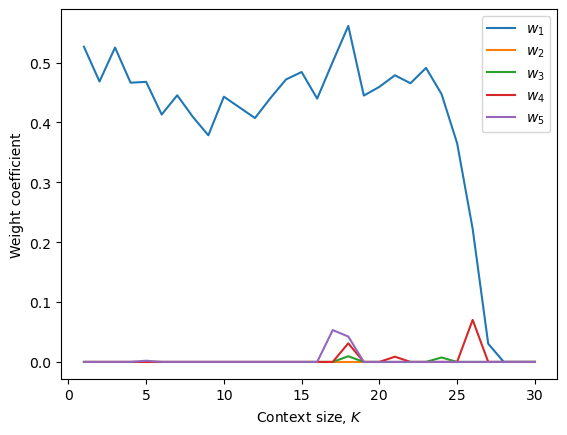

In [59]:
K_values = range(1, max_K + 1)
for i in range(5):
    plt.plot(K_values, weights[:,i])
plt.xlabel('Context size, $K$')
plt.ylabel('Weight coefficient')
plt.legend(['$w_'+str(i+1)+'$' for i in range(5)])
plt.show()

Observe that almost all coefficients $w_k$ for seasons $k$ years before the current season are effectively zero (plus noise), except for the immediately previous ($k=1$) season.
Also observe that $w_1(K)$ appears reasonable until about $K\approx 25$.

This single experiment suggests that only the ($K=1$) previous season offers any useful information to predict the current season. However, a single experiment may be spuriously  affected by
possibly unrepresentative sampling.
In order to try to overcome this problem, we now repeat the experiment multiple times and average over the results.

In [60]:
def run_multiple_experiments(team_data, num_experims, max_K, val_frac):
    all_est_scores =[]
    all_val_scores = []
    all_num_data = []

    for i in range(num_experims):
        print("Running experiment", i + 1, "...")
        _, est_scores, val_scores, num_data = run_one_experiment(team_data, val_frac, max_K)
        all_est_scores.append(est_scores)
        all_val_scores.append(val_scores)
        all_num_data.append(num_data)

    all_est_scores = np.mean(all_est_scores, axis=0)
    all_val_scores = np.mean(all_val_scores, axis=0)
    all_num_data = np.mean(all_num_data, axis=0)
    
    return all_est_scores, all_val_scores, all_num_data

In [61]:
num_experims = 20
max_K = 25

est_scores, val_scores, num_data = run_multiple_experiments(team_data, num_experims, max_K, val_frac)

Running experiment 1 ...
Running experiment 2 ...
Running experiment 3 ...
Running experiment 4 ...
Running experiment 5 ...
Running experiment 6 ...
Running experiment 7 ...
Running experiment 8 ...
Running experiment 9 ...
Running experiment 10 ...
Running experiment 11 ...
Running experiment 12 ...
Running experiment 13 ...
Running experiment 14 ...
Running experiment 15 ...
Running experiment 16 ...
Running experiment 17 ...
Running experiment 18 ...
Running experiment 19 ...
Running experiment 20 ...


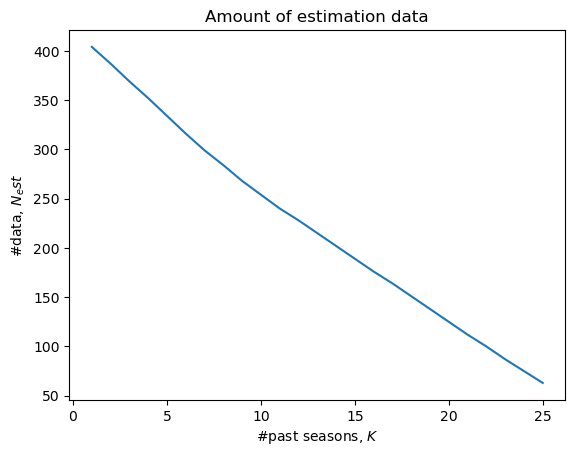

In [62]:
K_values = range(1, max_K + 1)
plt.plot(K_values, num_data)
plt.title("Amount of estimation data")
plt.xlabel("#past seasons, $K$")
plt.ylabel("#data, $N_est$")
plt.show()

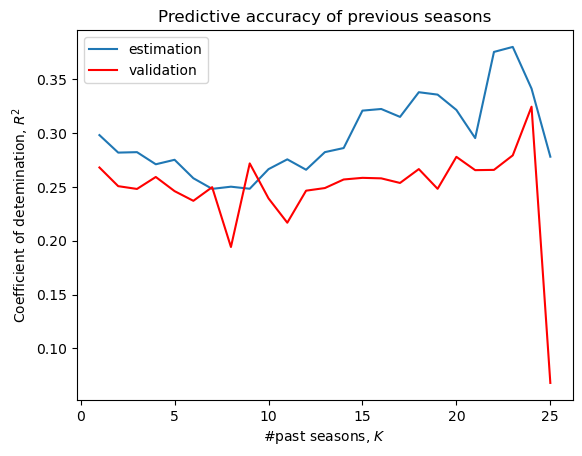

In [63]:
plt.plot(K_values, est_scores)
plt.plot(K_values, val_scores, 'r')
plt.title("Predictive accuracy of previous seasons")
plt.xlabel("#past seasons, $K$")
plt.ylabel("Coefficient of detemination, $R^2$")
plt.legend(['estimation', 'validation'])
plt.show()

Due to the randomisation, the experimental results vary at each run. Generallly, however,
we observe that the model behaves reasonably well for increasing $K$ until about $K\approx 15$, whereupon the validation score starts decreasing whilst the training score keeps increasing, indicating over-fittng (due to limited data). 
Note that for $K>25$ (not shown), the validation score actually becomes negative, as the 
model becomes worse than chance in explaining the residual variation.

We conclude that there appears to be little merit in using more than $K=1$ past seasons for a weighted, additive model. Other experiments (not shown here) also rule out using a weighted, multiplicative model. This is not unexpected, since, as noted at the end of the
[previous](#Temporal-averaging "Section: Temporal averaging") section,
a multiplicative weighting of probability estimates may be
transformed into an additively weighted model using the *logit* function. In other words, the predicted probability may also be represented via a *logistic* model of transformed probability estimates. However, this nonlinear transformation is clearly insufficient to extract further information from the seasonal time-series.

We have not yet ruled out other forms of multi-seasonal modelling, such as macro-averaging of statistics or analytics on multi-season match graphs. However, once again, other experiments (not shown here) suggest that the inclusion of further past seasons tends to add more noise to the
existing variation in the current season, and this extra variation degrades model performance.

Despite this, there might still be useful information hidden in the historical data. For example, if team A has never defated team B on team B's home ground, then this might be a strong indicator that team A's probability of winning is low, and we might be able to quantify this effect. 